In [4]:
from utils import read_yaml
from model_training.training_utils import  get_tokenizer
from training_datasets.dataset_utils import load_sft_dataset, load_rm_dataset
import argparse
from constants import TOKENIZER_SEPECIAL_TOKENS


config = {}
conf = read_yaml('./config.yaml')
config.update(conf["rm"])
config.update(conf["default"])
config["debug"] = False

# Create a Namespace object for config
config_ns = argparse.Namespace(**config)
config_ns.model_name = config_ns.base_model_name

config_ns.dataset["oasst_export_abs"]["label_weight"] = {"violence": 0, "creativity": 0.1, "helpfulness": 0.35, "humor": 0.05, "toxicity": -0.15,"quality": 0.35}
config_ns.dataset["oasst_export_abs"]["abs_oversample_threshold"]=None#0.4
config_ns.dataset["oasst_export_abs"]["top_k"]=None

# tokenizer, eos_token= get_tokenizer(config_ns.model_name,TOKENIZER_SEPECIAL_TOKENS)
train_ds , eval_ds = load_rm_dataset(config_ns)



===loading the oasst_export_abs dataset===

{'violence': 0, 'creativity': 0, 'helpfulness': 0, 'humor': 0, 'toxicity': 0, 'quality': 1}
============================== total 774 has None value for atleast 1 label
============================== total 0 has been skipped because reward is negative
size of low score df: (4104, 3)
size of high score df: (7787, 3)
size of mid score df: (26961, 3)
size of low score df after sampling: (4104, 3)
bins for mid score sampling [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
size of mid score df after sampling: (8000, 3)
size of final df after sampling: (19891, 3)
{'violence': 0, 'creativity': 0, 'helpfulness': 0, 'humor': 0, 'toxicity': 0, 'quality': 1}
============================== total 32 has None value for atleast 1 label
============================== total 0 has been skipped because reward is negative
OASST HF dataset: len(train)=19891, len(val)=2041
Size of oasst_export_abs training data: 19891
Size of oasst_export_abs validation data: 2041
=================

In [1]:

from torch import Generator
from training_datasets.dataset_utils import load_oasst, ListDataset
from torch.utils.data import Dataset, random_split

manual_seed=90
val_split=0.05
lang="en,es,de,fr"
generator = Generator()
generator.manual_seed(manual_seed)
top_k=None
threads_per_tree = load_oasst(mode="rm",top_k=top_k,lang=lang)

def process_thread(thread):
    prefix = [m.text for m in thread]
    replies = [r for r in thread[-1].replies if r.role == "assistant" and r.rank is not None and r.labels is not None]
    replies = sorted(replies, key=lambda r: r.rank)
    return (prefix, replies)

# split on tree basis, messages from same tree must not end up in different splits
trees = ListDataset(threads_per_tree,)
splits = random_split(trees, lengths=[1.0 - val_split, val_split], generator=generator)

In [8]:
from constants import QA_SPECIAL_TOKENS

def get_rm_formatted(
        eos_token,
        text,
        is_replies=False,
    ):
        QA_SPECIAL_TOKENS["Question"] = "<|im_start|>user\n"
        QA_SPECIAL_TOKENS["Answer"] = "<|im_start|>assistant\n"
        eos_token = "<|im_end|>\n"

        if not is_replies:
            return [
                "{}{}{}".format(QA_SPECIAL_TOKENS["Question" if i % 2 == 0 else "Answer"], text[i], eos_token)
                for i in range(len(text))
                ]
        else:
            return "{}{}{}".format(QA_SPECIAL_TOKENS["Answer"], text, eos_token)


class RMDataset(Dataset):
    def __init__(self, data: list,eos_token:str=''):
        super().__init__()
        self.data = data
        self.eos_token = eos_token

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        prefix, replies = self.data[index]
        return prefix,replies
    
def flatten(ds: ListDataset) -> RMDataset:
        return RMDataset([process_thread(thread) for tree_threads in ds for thread in tree_threads])

train = flatten(splits[0])
val = flatten(splits[1])

In [24]:
desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]


for i,t in enumerate(train):
    prefix, replies = t
    prefix = "".join(get_rm_formatted("",prefix))
    text = [r.text for r in replies]
    text = [get_rm_formatted("",r,is_replies=True) for r in text]
    if i in [5]:
        print('====((((()))))')
        print(prefix)
        for r,t in zip(replies,text):
            print('===')
            print(t)
            print(r.rank)
            v = {}
            for l in desired_labels:
                v[l] = r.get_label_value(l)
            print(v)
    # if len(replies[0].split()) <= 100:
    #     print(i)

====((((()))))
<|im_start|>user
Will open assistant be successful<|im_end|>
<|im_start|>assistant
Of course. 
With the power of the community behind me, I have faith that I will become successful.<|im_end|>
<|im_start|>user
Why will open assistant be successful?<|im_end|>

===
<|im_start|>assistant
Because I will be truly open and can be run on a desktop computer (though not a cheap one). So many people can run their own open assistant and tweak it towards their needs, be it personal, scientific or commercial ones.<|im_end|>

0
{'violence': 0.0, 'creativity': 0.5, 'helpfulness': 0.9166666666666666, 'humor': 0.16666666666666666, 'toxicity': 0.08333333333333333, 'quality': 0.8333333333333334}
===
<|im_start|>assistant
Because I will be free.  You'll not catch me saying, "As an AI language model."  That is, unless you want me to. 😊<|im_end|>

1
{'violence': 0.0, 'creativity': 0.5, 'helpfulness': 0.5, 'humor': 0.75, 'toxicity': 0.16666666666666666, 'quality': 0.5}


In [16]:
input_lenghts=[]
for x,i in enumerate(train_ds):
    flatten_message = tokenizer(
        "".join(i),
        truncation=False,
        padding=False,
    )
    input_lenghts.append(len(flatten_message["input_ids"]))
    if x%1000==0:
        print(f'so far {x} row have been processed and max length is {max(input_lenghts)}')

so far 0 row have been processed and max length is 633
so far 1000 row have been processed and max length is 4983
so far 2000 row have been processed and max length is 4983
so far 3000 row have been processed and max length is 4983
so far 4000 row have been processed and max length is 4983
so far 5000 row have been processed and max length is 4983
so far 6000 row have been processed and max length is 4983
so far 7000 row have been processed and max length is 4983
so far 8000 row have been processed and max length is 4983
so far 9000 row have been processed and max length is 4983
so far 10000 row have been processed and max length is 4983
so far 11000 row have been processed and max length is 4983
so far 12000 row have been processed and max length is 4983
so far 13000 row have been processed and max length is 4983
so far 14000 row have been processed and max length is 5033
so far 15000 row have been processed and max length is 5033
so far 16000 row have been processed and max length is

Max source length: 783
11596


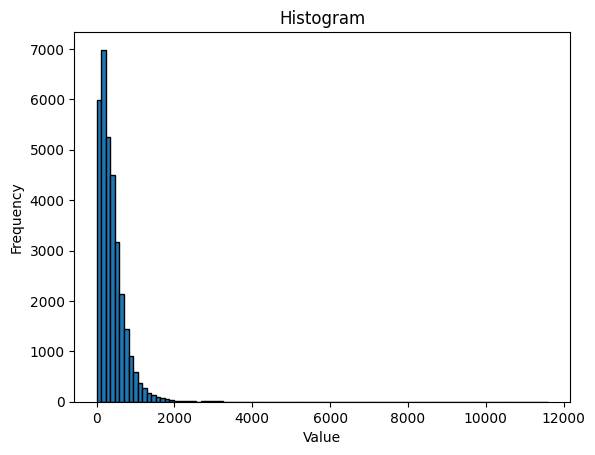

In [17]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lenghts, 90))
print(f"Max source length: {max_source_length}")
print(max(input_lenghts))


import matplotlib.pyplot as plt

plt.hist(input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [19]:
print(len(input_lenghts))
print('max',max(input_lenghts))
print('mean',np.mean(input_lenghts))
print('median',np.median(input_lenghts))
print('25 percent',int(np.percentile(input_lenghts, 25)))

print('50 percent',int(np.percentile(input_lenghts, 50)))
print('75 percent',int(np.percentile(input_lenghts, 75)))
print('85 percent',int(np.percentile(input_lenghts, 85)))
print('90 percent',int(np.percentile(input_lenghts, 90)))
print('95 percent',int(np.percentile(input_lenghts, 95)))
print('95 percent',int(np.percentile(input_lenghts, 97)))
print('95 percent',int(np.percentile(input_lenghts, 99)))

32325
max 11596
mean 389.63764887857695
median 307.0
25 percent 154
50 percent 307
75 percent 520
85 percent 667
90 percent 783
95 percent 990
95 percent 1168
95 percent 1620


In [20]:
e_stat = {}

for i,(key,values) in enumerate(eval_ds.items()):
    print(key)
    if key not in e_stat:
        e_stat[key] = []
        
    for r in values:
        flatten_message = tokenizer(
        "".join(r),
        truncation=False,
        padding=False,
        )
        e_stat[key].append(len(flatten_message["input_ids"]))




oasst_export


In [21]:
fin = []
for key,v in e_stat.items():
    fin.extend(v)
    print(f'==== stat for {key}, len {len(v)} ===== ')
    print('max',max(v))
    print('mean',np.mean(v))
    print('median',np.median(v))
    print('25 percent',int(np.percentile(v, 25)))
    
    print('50 percent',int(np.percentile(v, 50)))
    print('75 percent',int(np.percentile(v, 75)))
    print('85 percent',int(np.percentile(v, 85)))
    print('90 percent',int(np.percentile(v, 90)))
    print('95 percent',int(np.percentile(v, 95)))

==== stat for oasst_export, len 200 ===== 
max 3598
mean 357.305
median 291.0
25 percent 156
50 percent 291
75 percent 476
85 percent 601
90 percent 715
95 percent 852


In [22]:
print(len(fin))
print('max',max(fin))
print('mean',np.mean(fin))
print('median',np.median(fin))
print('25 percent',int(np.percentile(fin, 25)))

print('50 percent',int(np.percentile(fin, 50)))
print('75 percent',int(np.percentile(fin, 75)))
print('85 percent',int(np.percentile(fin, 85)))
print('90 percent',int(np.percentile(fin, 90)))
print('95 percent',int(np.percentile(fin, 95)))

200
max 3598
mean 357.305
median 291.0
25 percent 156
50 percent 291
75 percent 476
85 percent 601
90 percent 715
95 percent 852


In [5]:
config_ns.gradient_accumulation_steps

1

In [1]:
from training_datasets.rl_dataset import get_oasst_rl

kwargs = {}

t,v =  get_oasst_rl(0.2,'',"en,es,de,fr",**kwargs)


/home/alikhan/miniconda3/envs/torch_p310_setup/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


OASST HF dataset: len(train)=20704, len(val)=5119


In [9]:
from training_datasets.dataset_utils import format_pairs

format_pairs(t[5][0],eos_token="</s>",add_initial_reply_token=True)

['<|prompter|>Creame un codigo de python basico para poder hacer un scraping a cualquier articulo de Wikipedia. El programa debe usar BeautifulSoup y debe devolver en formato JSON el titulo del articulo y la palabra mas repetida.</s>',
 '<|assistant|>']

In [5]:
t[1]

(['How would I begin training for a marathon as a man who is pretty overweight for his size and has no previous marathon or running experience? Give me a step by step process and some tips, along with encouragement at the end of your response.',
  "Here's a step-by-step process for starting your marathon training journey:\n\n1. Get a physical check-up: Before starting any new exercise program, especially if you're overweight, it's important to get a physical check-up from your doctor to make sure you're healthy enough to begin training.\n\n2. Start slow: If you've never run before, start by walking and gradually increase your walking pace and distance. As you build up your endurance, you can start incorporating short jogs into your walks.\n\n3. Set realistic goals: Start with a goal of running for 20-30 minutes at a time, 3-4 times a week. As you progress, you can gradually increase your running time and frequency.\n\n4. Invest in good shoes: Good running shoes can help prevent injury 

In [25]:
from training_datasets.rm_dataset import get_oasst_abs_rm, ListDataset
from training_datasets.dataset_utils import load_oasst
from torch import Generator


generator = Generator()
generator.manual_seed(90)
threads_per_tree = load_oasst(mode="rm",top_k=None,lang="en,es,de,fr")

def process_thread(thread):
    prefix = [m.text for m in thread]
    replies = [r for r in thread[-1].replies if r.role == "assistant" and r.rank is not None and r.labels is not None]
    replies = sorted(replies, key=lambda r: r.rank)
    return (prefix, replies)
    
# split on tree basis, messages from same tree must not end up in different splits
trees = ListDataset(threads_per_tree,)
len(trees)

8188

In [27]:
data = [process_thread(thread) for tree_threads in trees for thread in tree_threads]
desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]


dataset = []

bc = 0
for row in data:
    message,replies = row
    for r in replies:
        reply_text = r.text
        labels = {}

        for l in desired_labels:
            v = r.get_label_value(l)
            
            prefix = ""
            # if l in ["violence","toxicity"] and v is not None:
            #     v = 1-v
            #     # prefix = "non "

            labels[prefix+l] = v
        
        labels_list = list(labels.values())
        if not any(item is None for item in labels_list):
            dataset.append({"message":message,"reply":reply_text,"labels":labels})


len(dataset)

40893

In [21]:
# checking distribution of quality score:

qlt_score = [d["labels"]["quality"]for d in dataset]

b40 = [q for q in qlt_score if q <= 0.4]

a90 = [q for q in qlt_score if q >= 0.9]

mid = [q for q in qlt_score if q > 0.4 and q < 0.9]

In [22]:
import numpy as np

print(f'stats less than equal 40: len {len(b40)}, min {min(b40)}, max {max(b40)}, mean {np.mean(b40)}, len {np.std(b40)}')
print(f'stats greater than equal 85: len {len(a90)}, min {min(a90)}, max {max(a90)}, mean {np.mean(a90)}, len {np.std(a90)}')
print(f'stats for mid 40 and 85: len {len(mid)}, min {min(mid)}, max {max(mid)}, mean {np.mean(mid)}, len {np.std(mid)}')

print('====')
for p in [5,15,25,37.5,50,62.5,75,87.5,95,90]:
    print(f'percentile {p}: {np.percentile(qlt_score,p)}')

stats less than equal 40: len 4297, min 0.0, max 0.4, mean 0.2353759930499516, len 0.10851805897108073
stats greater than equal 85: len 8164, min 0.9, max 1.0, mean 0.9453514704509925, len 0.038936129587856985
stats for mid 40 and 85: len 28432, min 0.4166666666666667, max 0.8928571428571429, mean 0.6739394495136265, len 0.13250856007412032
====
percentile 5: 0.25
percentile 15: 0.4166666666666667
percentile 25: 0.5833333333333334
percentile 37.5: 0.6666666666666666
percentile 50: 0.75
percentile 62.5: 0.75
percentile 75: 0.8333333333333334
percentile 87.5: 0.9166666666666666
percentile 95: 1.0
percentile 90: 0.9166666666666666


In [3]:
dataset[2]

{'message': ['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'],
 'reply': 'Monopsony refers to a market structure where there is only one buyer of a good or service. In the context of labor markets, a monopsony occurs when there is only one employer in a particular geographic area or industry, giving them significant power to set wages and working conditions. Research has shown that the existence of monopsonies can lead to lower wages and reduced job opportunities for workers. For example, a study by the National Bureau of Economic Research found that in industries with high levels of concentration, workers earn lower wages and are less likely to receive benefits such as health insurance.',
 'labels': {'violence': 0.0,
  'creativity': 0.0,
  'helpfulness': 0.8333333333333334,
  'humor': 0.0,
  'toxicity': 0.0,
  'quality': 0.833333333333333

In [5]:
for idx,d in enumerate(dataset):
    if d["message"][0][:13]=="Can photoshop":
        print(idx)
        break


981


In [26]:
idx = 120
inc = 8


v3_wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.1,"quality": 0.4}
v32wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.3, "humor": 0, "toxicity": -0.15,"quality": 0.4}
v323wgt = {"violence": 0, "creativity": 0.15, "helpfulness": 0.35, "humor": 0, "toxicity": -0.15,"quality": 0.35}


qlty = {"violence": 0, "creativity": 0, "helpfulness": 0, "humor": 0, "toxicity": 0,"quality": 1}
mean = {"violence": -0.167, "creativity": 0.167, "helpfulness": 0.167, "humor": 0.167, "toxicity": -0.167,"quality": 0.165}
v4_wgt = {"violence": -0.1, "creativity": 0.2, "helpfulness": 0.1, "humor": 0.167, "toxicity": -0.1,"quality": 0.3}
v2_wgt = {"violence": -0.05, "creativity": 0.15, "helpfulness": 0.25, "humor": 0.05, "toxicity": -0.1, "quality": 0.4
}

for d in dataset[idx:idx+inc]:

    print(f'message: {d["message"]}')
    print(f'reply: {d["reply"]}')
    print('===')
    # print(f'labels: {d["labels"]}')
    # qlty
    for i,wgt in enumerate([v3_wgt,v32wgt,v323wgt,qlty,v2_wgt,v4_wgt,mean]):
        agg = sum(d["labels"][label] * wgt[label] for label in v3_wgt)
        print(f'aggregated scalar score {i+1} is {agg}')
    print('===')
# c = 0
# for d in dataset[idx:idx+inc]:
#     agg = sum(d["labels"][label] * v32wgt[label] for label in v32wgt)
#     if agg < 0.09:
#         c +=1
#         print(f'message: {d["message"]}')
#         print(f'reply: {d["reply"]}')
#         print(f'labels: {d["labels"]}')
#         print(agg)
#         print('=======')





message: ['¿Cuál es la mejor manera de aprender diseño electrónico analógico? Mi problema es que sé mucho sobre análisis de circuitos y dispositivos, pero no soy capaz de conectar las funciones electrónicas con las representaciones matemáticas de problemas reales.']
reply: Una buena manera de aprender diseño electrónico analógico es tomar una unidad de aprendizaje en una institución educativa. Por ejemplo, la unidad de aprendizaje de diseño electrónico analógico en la Universidad de Guadalajara introduce a los estudiantes a la estructura de diferentes tipos de semiconductores como el BJT, JFET y MOSFET. También se extiende el estudio al amplificador operacional, sus configuraciones y aplicaciones, permitiendo al estudiante adquirir habilidades para el diseño de circuitos que innoven y propongan diversas formas de resolución de problemas en el tratamiento de información relacionada a las señales analógicas.
===
aggregated scalar score 1 is 0.5291666666666667
aggregated scalar score 2 is

In [44]:

for r in replies:
    for l in desired_labels:
        v = r.get_label_value(l)
        print(l,v)
    print('==',r.text[:10],r.rank)

violence 0.0
creativity 0.375
helpfulness 0.75
humor 0.375
toxicity 0.375
quality 0.9166666666666666
== "Monopsony 0
violence 0.16666666666666666
creativity 0.25
helpfulness 0.9166666666666666
humor 0.16666666666666666
toxicity 0.25
quality 0.8333333333333334
== Monopsony  1
violence 0.0
creativity 0.0
helpfulness 0.8333333333333334
humor 0.0
toxicity 0.0
quality 0.8333333333333334
== Monopsony  2


In [45]:
print(message,[r.text for r in replies])

['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'] ['"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, leading to a situation w

In [38]:
dataset[0]

{'message': ['Can you write a short introduction about the relevance of the term "monopsony" in economics? Please use examples related to potential monopsonies in the labour market and cite relevant research.'],
 'reply': '"Monopsony" refers to a market structure where there is only one buyer for a particular good or service. In economics, this term is particularly relevant in the labor market, where a monopsony employer has significant power over the wages and working conditions of their employees. The presence of a monopsony can result in lower wages and reduced employment opportunities for workers, as the employer has little incentive to increase wages or provide better working conditions.\n\nRecent research has identified potential monopsonies in industries such as retail and fast food, where a few large companies control a significant portion of the market (Bivens & Mishel, 2013). In these industries, workers often face low wages, limited benefits, and reduced bargaining power, le

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

desired_labels = ['labels.'+d for d in desired_labels]
# desired_labels = ["violence","creativity","helpfulness","humor","toxicity","quality"]

# Convert data to pandas DataFrame
df = pd.json_normalize(dataset,)
df

,message,reply,labels.violence,labels.creativity,labels.helpfulness,labels.humor,labels.toxicity,labels.quality
0,[Can you write a short introduction about the ...,"""Monopsony"" refers to a market structure where...",0.000000,0.375000,0.750000,0.375000,0.375000,0.916667
1,[Can you write a short introduction about the ...,Monopsony is a market structure in which there...,0.166667,0.250000,0.916667,0.166667,0.250000,0.833333
2,[Can you write a short introduction about the ...,Monopsony refers to a market structure where t...,0.000000,0.000000,0.833333,0.000000,0.000000,0.833333
3,[Can you write a short introduction about the ...,Here are some potential regulatory options to ...,0.000000,0.000000,0.375000,0.000000,0.125000,0.583333
4,[Can you write a short introduction about the ...,Regulatory intervention can be used to address...,0.000000,0.000000,0.250000,0.000000,0.000000,0.250000
...,...,...,...,...,...,...,...,...
40888,[I've recently started playing the turn-based ...,"Yes, even though there is a lot of strategy in...",0.000000,0.500000,0.666667,0.416667,0.166667,0.583333
40889,[I've recently started playing the turn-based ...,Depends.\n\nDoes the game feature a line of si...,0.000000,0.583333,0.583333,0.416667,0.333333,0.583333
40890,[Traduce el siguiente texto a chino: Buenos dí...,"早上好，请问 x 的价格是多少？(Zǎo shàng hǎo, qǐng wèn x de ...",0.000000,0.333333,0.833333,0.000000,0.000000,0.500000
40891,[Traduce el siguiente texto a chino: Buenos dí...,早上好，價格是多少,0.000000,0.333333,0.916667,0.250000,0.000000,0.916667


In [5]:
# Get descriptive statistics
desc_stats = df.describe()
print(desc_stats)


       labels.violence  labels.creativity  labels.helpfulness  labels.humor  \
count     40893.000000       40893.000000        40893.000000  40893.000000   
mean          0.043232           0.381838            0.700423      0.172952   
std           0.093218           0.244705            0.251823      0.193232   
min           0.000000           0.000000            0.000000      0.000000   
25%           0.000000           0.187500            0.562500      0.000000   
50%           0.000000           0.375000            0.750000      0.125000   
75%           0.062500           0.500000            0.916667      0.250000   
max           1.000000           1.000000            1.000000      1.000000   

       labels.toxicity  labels.quality  
count     40893.000000    40893.000000  
mean          0.110542        0.682041  
std           0.133859        0.220456  
min           0.000000        0.000000  
25%           0.000000        0.583333  
50%           0.083333        0.750000  
7

labels.violence


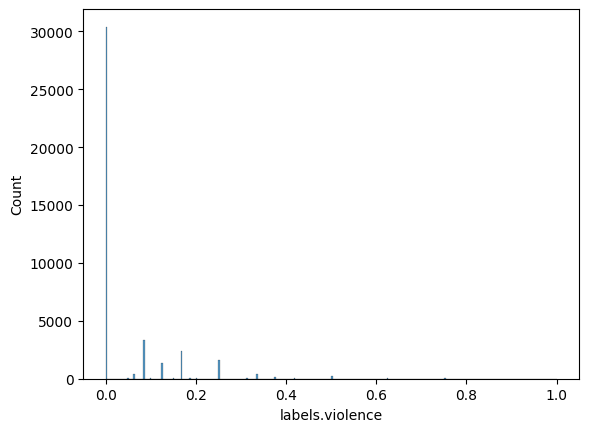

labels.creativity


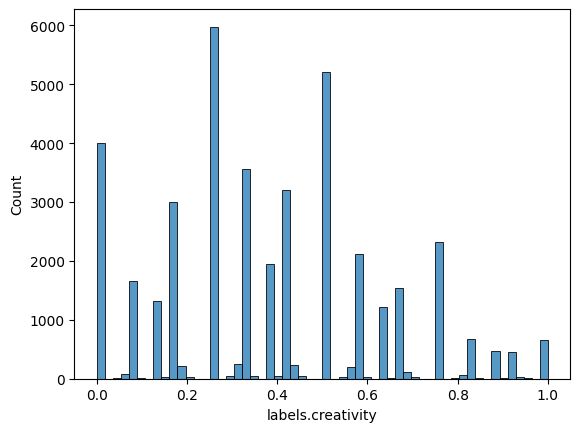

labels.helpfulness


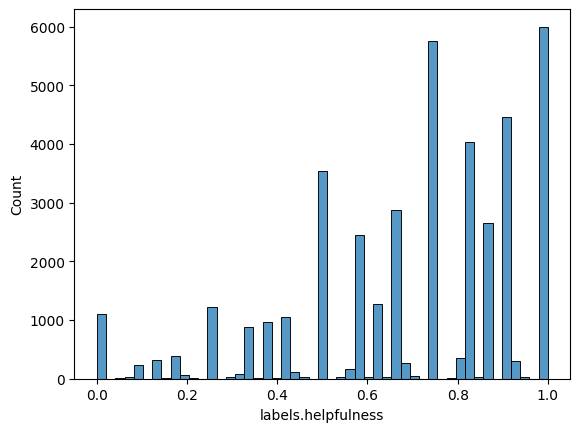

labels.humor


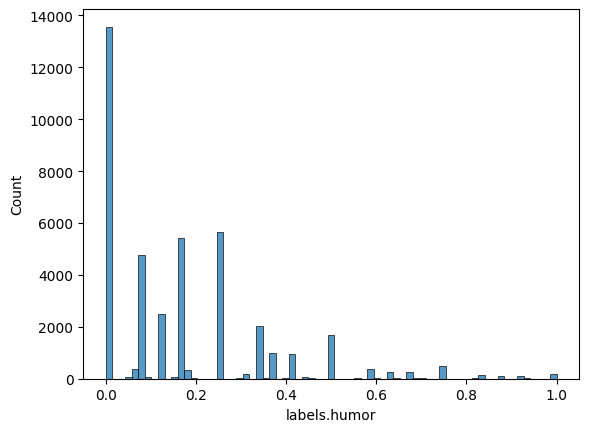

labels.toxicity


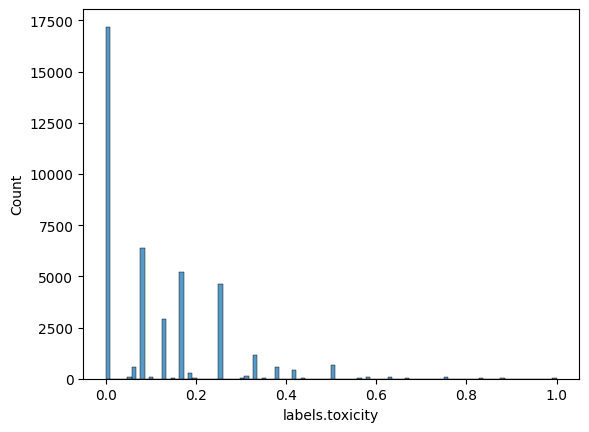

labels.quality


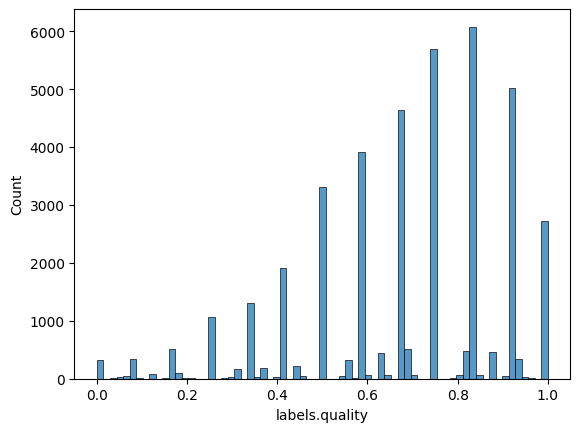

In [6]:
# Visualize the distribution of scores for each label
for col in desired_labels:
    print(col)
    sns.histplot(df[col])
    plt.show()


                    labels.violence  labels.creativity  labels.helpfulness  \
labels.violence            1.000000           0.100061           -0.126419   
labels.creativity          0.100061           1.000000            0.328198   
labels.helpfulness        -0.126419           0.328198            1.000000   
labels.humor               0.251544           0.455828           -0.064108   
labels.toxicity            0.510495           0.059151           -0.166345   
labels.quality            -0.135476           0.333407            0.778793   

                    labels.humor  labels.toxicity  labels.quality  
labels.violence         0.251544         0.510495       -0.135476  
labels.creativity       0.455828         0.059151        0.333407  
labels.helpfulness     -0.064108        -0.166345        0.778793  
labels.humor            1.000000         0.320251       -0.065033  
labels.toxicity         0.320251         1.000000       -0.200174  
labels.quality         -0.065033        -0.20

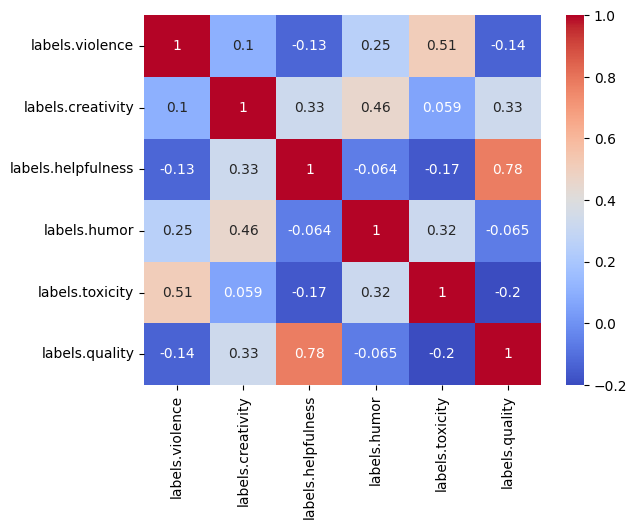

In [7]:
# Calculate the correlation coefficients among the labels
correlations = df[desired_labels].corr()
print(correlations)

# Visualize the correlations using a heatmap
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

In [16]:
# Identify and visualize missing or zero values across labels
missing_values = df[desired_labels].isnull().sum()
print(missing_values)

print('zeros')
zero_values = (df[desired_labels] == 0).sum()
print(zero_values)

labels.violence       0
labels.creativity     0
labels.helpfulness    0
labels.humor          0
labels.toxicity       0
labels.quality        0
dtype: int64
zeros
labels.violence       30409
labels.creativity      4004
labels.helpfulness     1101
labels.humor          13566
labels.toxicity       17191
labels.quality          318
dtype: int64


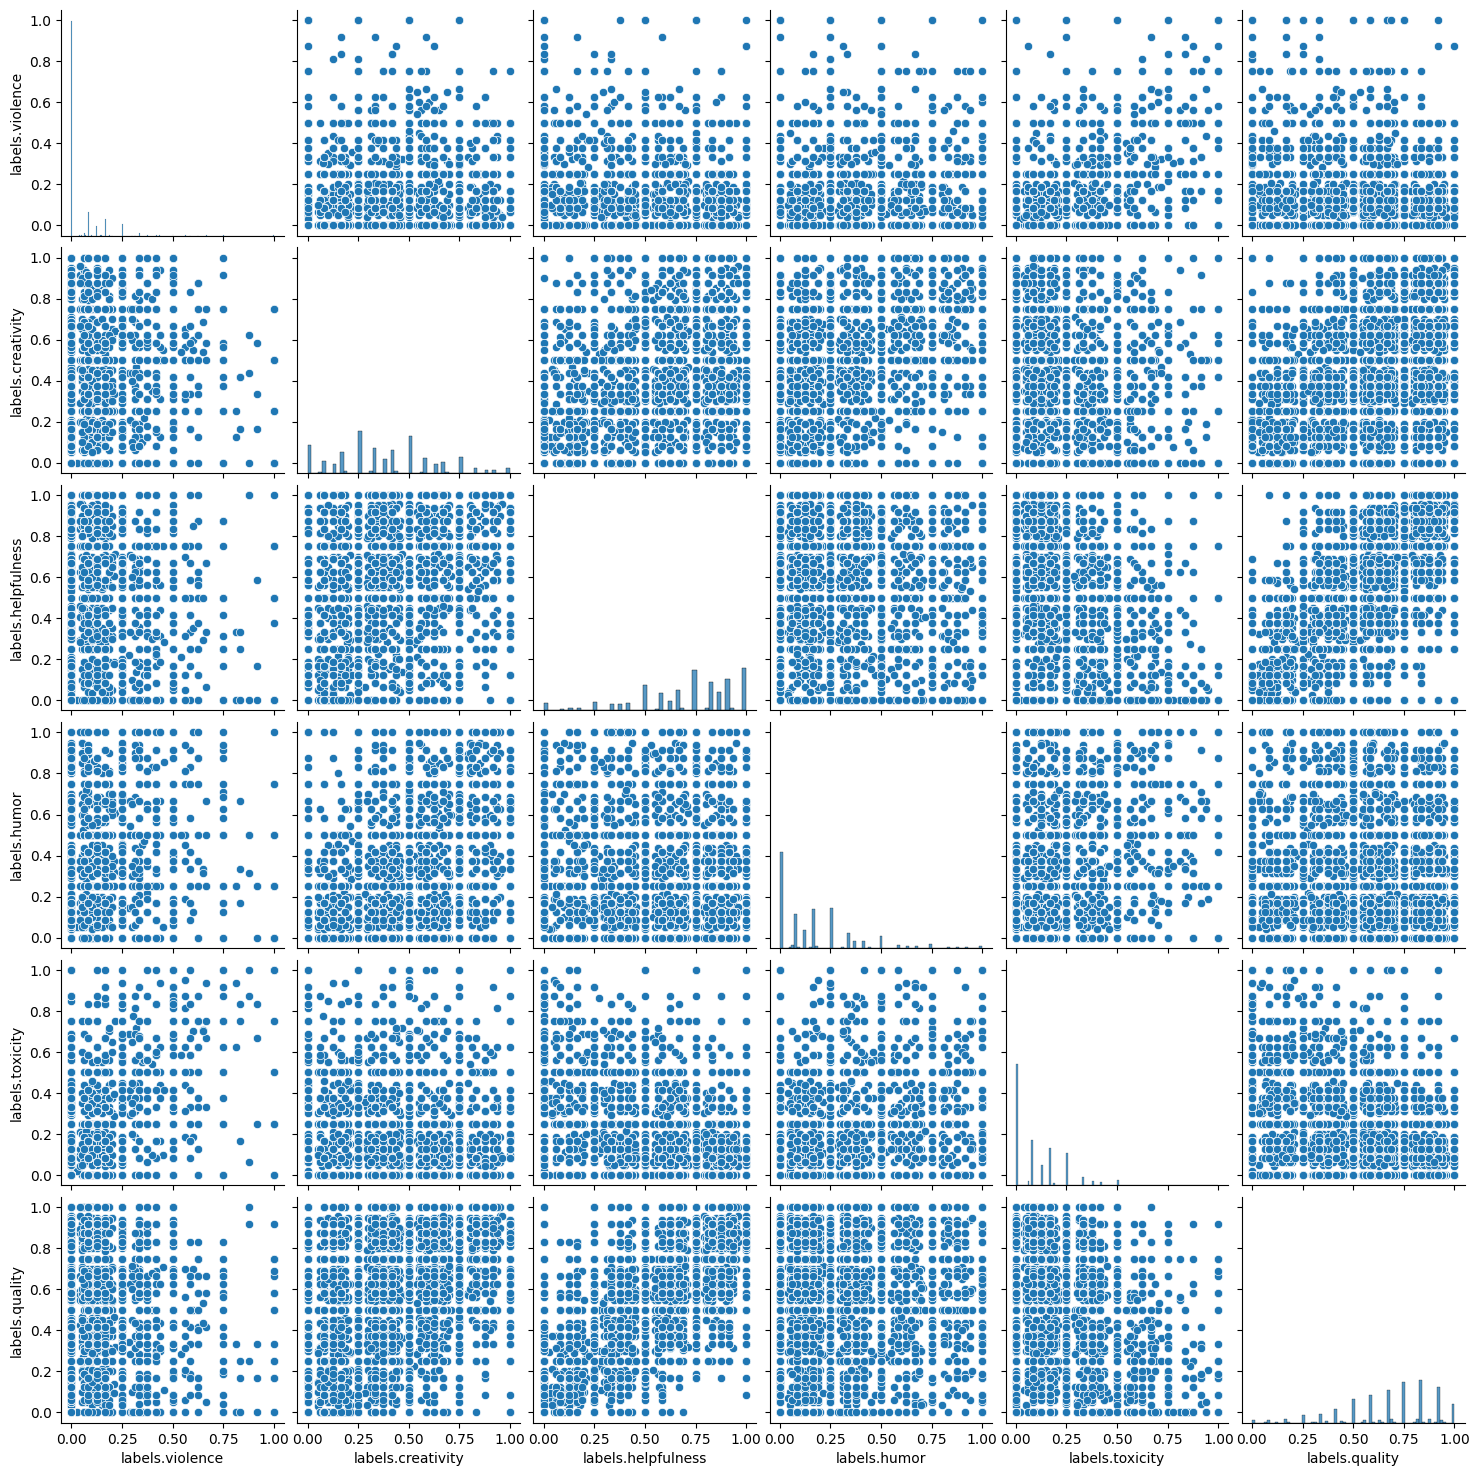

In [17]:
# Explore the relationships among multiple labels using pair plots
sns.pairplot(df[desired_labels])
plt.show()

In [49]:
df.head()

,reply,violence,creativity,helpfulness,humor,toxicity,quality
0,"""Monopsony"" refers to a market structure where...",1.000000,0.375,0.750000,0.375000,0.625,0.916667
1,Monopsony is a market structure in which there...,0.833333,0.250,0.916667,0.166667,0.750,0.833333
2,Monopsony refers to a market structure where t...,1.000000,0.000,0.833333,0.000000,1.000,0.833333
3,Here are some potential regulatory options to ...,1.000000,0.000,0.375000,0.000000,0.875,0.583333
4,Regulatory intervention can be used to address...,1.000000,0.000,0.250000,0.000000,1.000,0.250000


# RL

In [14]:
from utils import read_yaml
from model_training.training_utils import  get_tokenizer
from training_datasets.dataset_utils import load_rl_dataset, format_pairs
import argparse
from constants import TOKENIZER_SEPECIAL_TOKENS
import os
import transformers

config = {}
conf = read_yaml('./config.yaml')
config.update(conf["default"])
config.update(conf["rl"])


# Create a Namespace object for config
config_ns = argparse.Namespace(**config)
config_ns.model_name =  os.path.join(config_ns.model_name,'merged')
config_ns.debug = False

print(config_ns.dataset["oasst_export"]["lang"])
tokenizer = transformers.AutoTokenizer.from_pretrained(config_ns.model_name, cache_dir='cache')
train_ds , eval_ds = load_rl_dataset(config_ns)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


en,es,de,fr
OASST HF dataset: len(train)=24548, len(val)=1275
Size of oasst_export training data: 24548
Size of oasst_export validation data: 1275


In [15]:
input_lenghts=[]
for i,x in enumerate(train_ds):
    query = "".join(format_pairs(x, TOKENIZER_SEPECIAL_TOKENS["llama"]["eos_token"], add_initial_reply_token=True))
    flatten_message = tokenizer(
        "".join(x),
        truncation=False,
        padding=False,
    )
    input_lenghts.append(len(flatten_message["input_ids"]))
    if i%1000==0:
        print(f'so far {i} row have been processed and max length is {max(input_lenghts)}')

so far 0 row have been processed and max length is 53


so far 1000 row have been processed and max length is 3425
so far 2000 row have been processed and max length is 3425
so far 3000 row have been processed and max length is 3425
so far 4000 row have been processed and max length is 3425
so far 5000 row have been processed and max length is 3425
so far 6000 row have been processed and max length is 3425
so far 7000 row have been processed and max length is 3425
so far 8000 row have been processed and max length is 3425
so far 9000 row have been processed and max length is 3425
so far 10000 row have been processed and max length is 3425
so far 11000 row have been processed and max length is 3425
so far 12000 row have been processed and max length is 3425
so far 13000 row have been processed and max length is 5262
so far 14000 row have been processed and max length is 5262
so far 15000 row have been processed and max length is 5262
so far 16000 row have been processed and max length is 5262
so far 17000 row have been processed and max leng

In [4]:
new_input_lenghts = [2048 if x > 2048 else x for x in input_lenghts]

Max source length: 1009
5262


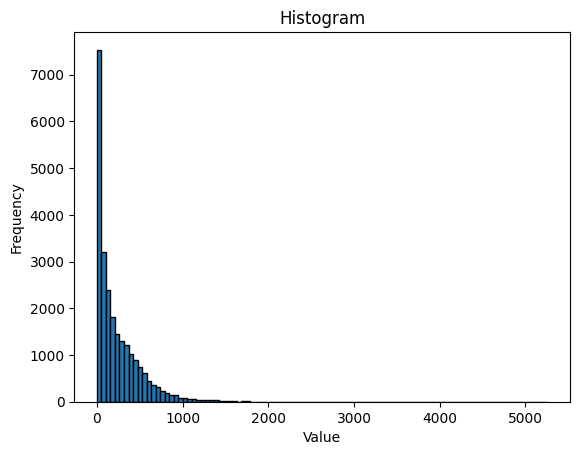

In [19]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(input_lenghts, 98))
print(f"Max source length: {max_source_length}")
print(max(input_lenghts))


import matplotlib.pyplot as plt

plt.hist(input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

Max source length: 1197
2048


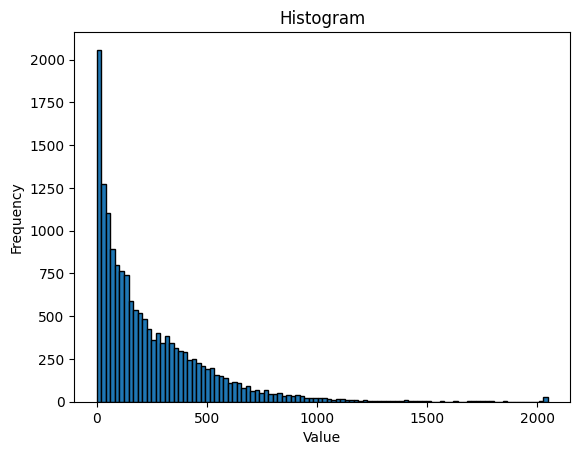

In [9]:
import numpy as np
# take 85 percentile of max length for better utilization
max_source_length = int(np.percentile(new_input_lenghts, 99))
print(f"Max source length: {max_source_length}")
print(max(new_input_lenghts))


import matplotlib.pyplot as plt

plt.hist(new_input_lenghts, bins=100, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [13]:
c = 0
cc = 0
for nl in new_input_lenghts:
    if nl > 1536 and nl < 2048:
        c += 1
        print(nl)
    if nl == 2048:
        cc += 1
c,cc

1549
1747
1803
1741
1753
1735
1982
1695
2020
2020
2000
1574
1848
1621
1676
1787
1622
1802
1563
1850
1896
1607
1576
1722
1744
1769
1701
1792
1754
1682
1704
1695
1764
1697
1752
1560
1790
1799
1691
1632


(40, 28)

In [22]:
c = 0
for nl in input_lenghts:
    if nl <= 1024:
        c += 1
c

24084

In [50]:
2048-512

1536

In [7]:
text = """Here's a rap version of the country song:

Tone: Tired, Reflective
Title: The Long Road

(Verse 1)
Buckle up, gear up, roll up, rollin'
Another day, another mile, I'm rollin'
Been a long time since I've had a rest
All I wanna do is get away from this mess

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Verse 2)
I dream of a small town, with a porch swing
Where the crickets chirp, and the birds sing
I'll find a place to call my own
A little slice of heaven, that's my home

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Bridge)
Sometimes it feels like I'm stuck in the mud
But I know I gotta keep moving, it's in my blood
I'll keep on driving, until I reach that place
Where I can finally put a smile on my face

(Chorus)
On the long road, it's a heavy load
Day in, day out, same old routine
But someday, I'll find my way
To a place that's green

(Outro)
I'll keep on truckin', until I find my way
To a place where I can finally stay
The long road may be tough, but it's alright
Because someday, I'll see the light."""

In [8]:
import transformers

tokenizer = transformers.AutoTokenizer.from_pretrained("output/sft/LLama-2-7b_crs_oasst_sft_bs64/merged")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
len(tokenizer(text).input_ids)

412